# Predição de Temperatura com CNN 1D - TinyML

**Projeto:** Sistema de Predição de Temperatura para Microcontroladores

**Objetivo:** Prever a temperatura do sensor AHT20 em 5, 10 e 15 minutos no futuro

**Sensores utilizados:**
- AHT20: Temperatura e Umidade
- BMP280: Temperatura e Pressão

**Modelo:** CNN 1D (Convolutional Neural Network 1D) compatível com TensorFlow Lite Micro

**Deploy:** Raspberry Pi Pico (RP2040)

---

# 1. Carregar os Dados

---

In [20]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Sklearn para pré-processamento e métricas
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Configurar seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}')
print(f'Seed configurado: {SEED}')

TensorFlow: 2.20.0
Seed configurado: 42


In [21]:
# Carregar o dataset de temperatura
df_raw = pd.read_csv('data/temp.csv')

# Converter coluna de timestamp para datetime
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'])

print(f'Dataset completo carregado!')
print(f'Shape original: {df_raw.shape}')
print(f'Colunas disponíveis: {list(df_raw.columns)}')

Dataset completo carregado!
Shape original: (82430, 12)
Colunas disponíveis: ['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C', 'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C', 'Umid_DHT11_pct']


In [22]:
# Selecionar apenas as features de interesse
features = ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
df = df_raw[['Timestamp'] + features].copy()

print(f'\nDataset filtrado:')
print(f'Shape: {df.shape}')
print(f'Features selecionadas: {features}')
print(f'Período dos dados: {df["Timestamp"].min()} até {df["Timestamp"].max()}')
print(f'\nPrimeiras linhas:')
df.head()


Dataset filtrado:
Shape: (82430, 5)
Features selecionadas: ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
Período dos dados: 2025-08-31 22:31:02 até 2025-09-30 16:52:09

Primeiras linhas:


,Timestamp,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa
0,2025-08-31 22:31:02,19.90,73.37,21.28,921.24
1,2025-08-31 22:31:33,19.97,75.57,21.48,921.12
2,2025-08-31 22:32:05,19.75,74.31,21.25,921.20
3,2025-08-31 22:32:36,19.55,74.77,21.07,921.15
4,2025-08-31 22:33:07,19.60,75.09,21.12,921.25


In [23]:
# Informações sobre as colunas do dataset
print('Informações do dataset:')
print(df.info())
print('\n' + '='*70)
print('Estatísticas descritivas:')
df.describe()

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82430 entries, 0 to 82429
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Timestamp         82430 non-null  datetime64[ns]
 1   Temp_AHT20_C      82430 non-null  float64       
 2   Umid_AHT20_pct    82430 non-null  float64       
 3   Temp_BMP280_C     82430 non-null  float64       
 4   Press_BMP280_hPa  82430 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.1 MB
None

Estatísticas descritivas:


,Timestamp,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa
count,82430,82430.000000,82430.000000,82430.000000,82430.000000
mean,2025-09-15 19:31:51.557382144,20.328970,65.946394,21.803339,918.146819
min,2025-08-31 22:31:02,13.440000,35.440000,15.120000,912.100000
25%,2025-09-08 08:52:53.750000128,17.610000,54.520000,19.160000,916.600000
50%,2025-09-15 19:19:27.500000,19.750000,68.950000,21.240000,918.300000
75%,2025-09-23 06:09:26.249999872,22.990000,77.310000,24.400000,919.790000
max,2025-09-30 16:52:09,29.390000,92.130000,30.590000,922.990000
std,NaN,3.452443,13.343084,3.350503,2.147400


# 2. Análise Exploratória de Dados (EDA)

---

In [24]:
# Verificar valores nulos
print('Valores nulos por coluna:')
print(df.isna().sum())
print(f'\nTotal de valores nulos: {df.isna().sum().sum()}')

# Se houver nulos, remover
if df.isna().sum().sum() > 0:
    print(f'\nRemovendo {df.isna().sum().sum()} linhas com valores nulos...')
    df = df.dropna()
    print(f'Novo shape: {df.shape}')
else:
    print('\nNenhum valor nulo encontrado! Dataset limpo.')

Valores nulos por coluna:
Timestamp           0
Temp_AHT20_C        0
Umid_AHT20_pct      0
Temp_BMP280_C       0
Press_BMP280_hPa    0
dtype: int64

Total de valores nulos: 0

Nenhum valor nulo encontrado! Dataset limpo.


In [25]:
# Calcular frequência de amostragem
print('Análise da frequência de amostragem:')
print('='*70)

time_diffs = df['Timestamp'].diff()
print('\nDiferenças de tempo entre amostras consecutivas:')
print(time_diffs.value_counts().head(10))

avg_interval = time_diffs.median()
print(f'\nIntervalo mediano: {avg_interval}')
print(f'Frequência de amostragem: {avg_interval.total_seconds():.1f} segundos')
print(f'Isso equivale a: {60/avg_interval.total_seconds():.2f} amostras por minuto')

Análise da frequência de amostragem:

Diferenças de tempo entre amostras consecutivas:
Timestamp
0 days 00:00:31    66852
0 days 00:00:32    15576
0 days 00:13:43        1
Name: count, dtype: int64

Intervalo mediano: 0 days 00:00:31
Frequência de amostragem: 31.0 segundos
Isso equivale a: 1.94 amostras por minuto


## 2.1. Visualização das Séries Temporais

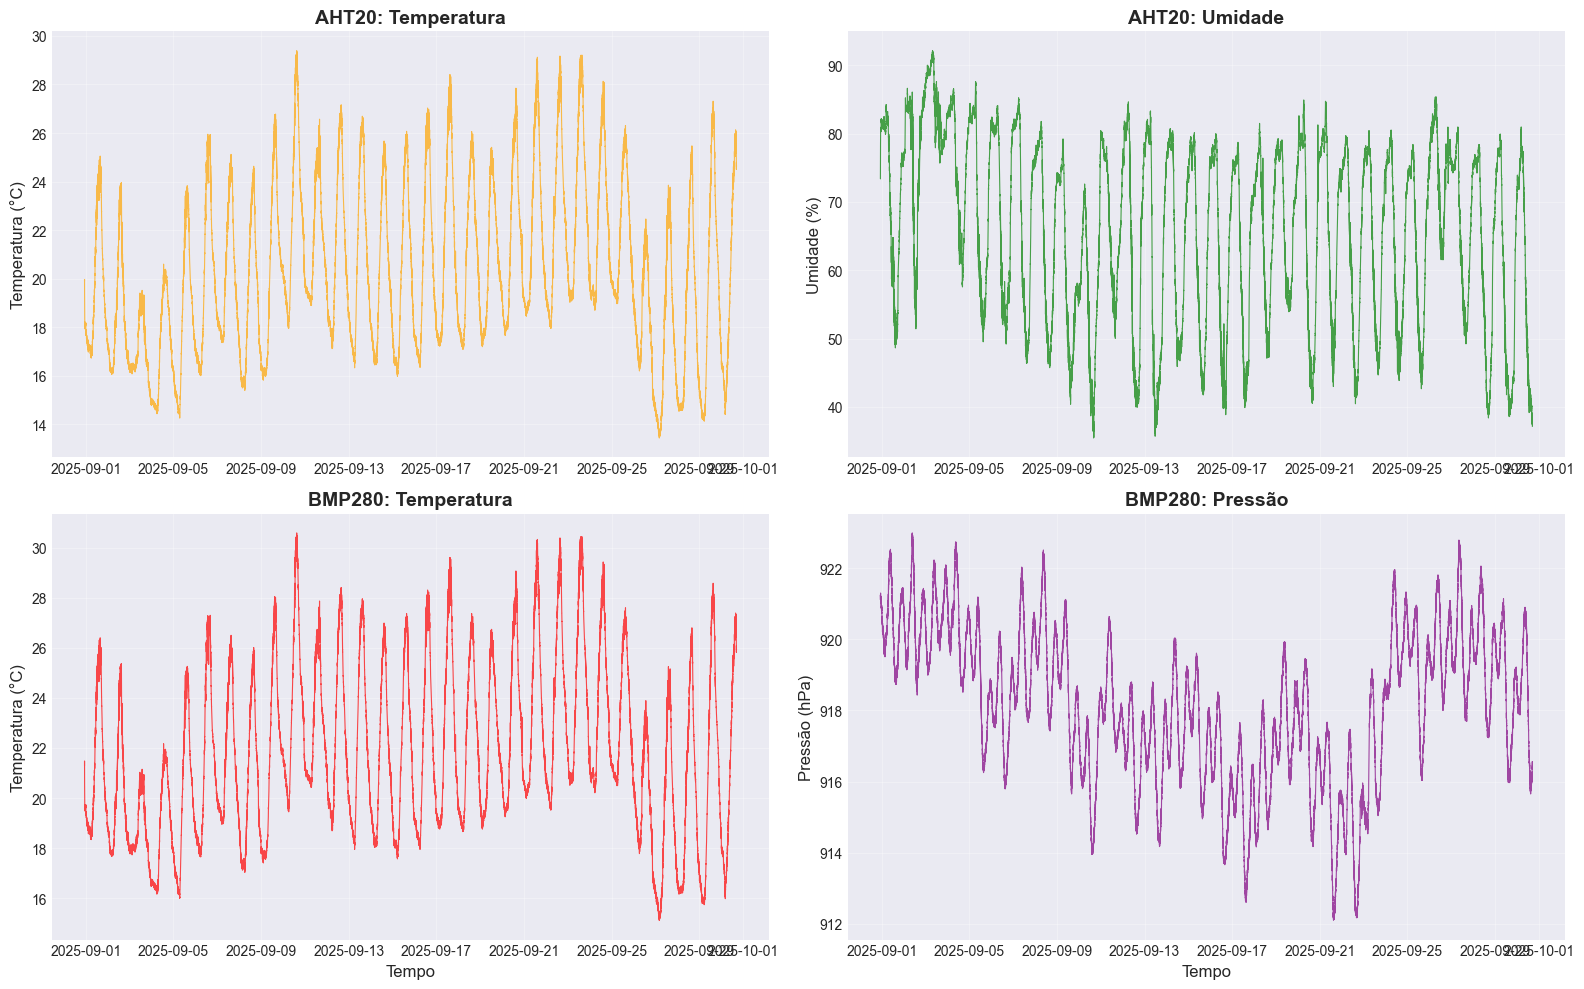

Gráfico salvo: images/Conv1D/01_series_temporais.png


In [26]:
# Criar pasta images/Conv1D se não existir
import os
os.makedirs('images/Conv1D', exist_ok=True)

# Visualizar as séries temporais dos sensores
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# AHT20: Temperatura
axes[0, 0].plot(df['Timestamp'], df['Temp_AHT20_C'], linewidth=0.8, alpha=0.7, color='orange')
axes[0, 0].set_ylabel('Temperatura (°C)', fontsize=12)
axes[0, 0].set_title('AHT20: Temperatura', fontweight='bold', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# AHT20: Umidade
axes[0, 1].plot(df['Timestamp'], df['Umid_AHT20_pct'], linewidth=0.8, alpha=0.7, color='green')
axes[0, 1].set_ylabel('Umidade (%)', fontsize=12)
axes[0, 1].set_title('AHT20: Umidade', fontweight='bold', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# BMP280: Temperatura
axes[1, 0].plot(df['Timestamp'], df['Temp_BMP280_C'], linewidth=0.8, alpha=0.7, color='red')
axes[1, 0].set_ylabel('Temperatura (°C)', fontsize=12)
axes[1, 0].set_xlabel('Tempo', fontsize=12)
axes[1, 0].set_title('BMP280: Temperatura', fontweight='bold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# BMP280: Pressão
axes[1, 1].plot(df['Timestamp'], df['Press_BMP280_hPa'], linewidth=0.8, alpha=0.7, color='purple')
axes[1, 1].set_ylabel('Pressão (hPa)', fontsize=12)
axes[1, 1].set_xlabel('Tempo', fontsize=12)
axes[1, 1].set_title('BMP280: Pressão', fontweight='bold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/Conv1D/01_series_temporais.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/01_series_temporais.png')

## 2.2. Distribuição das Features

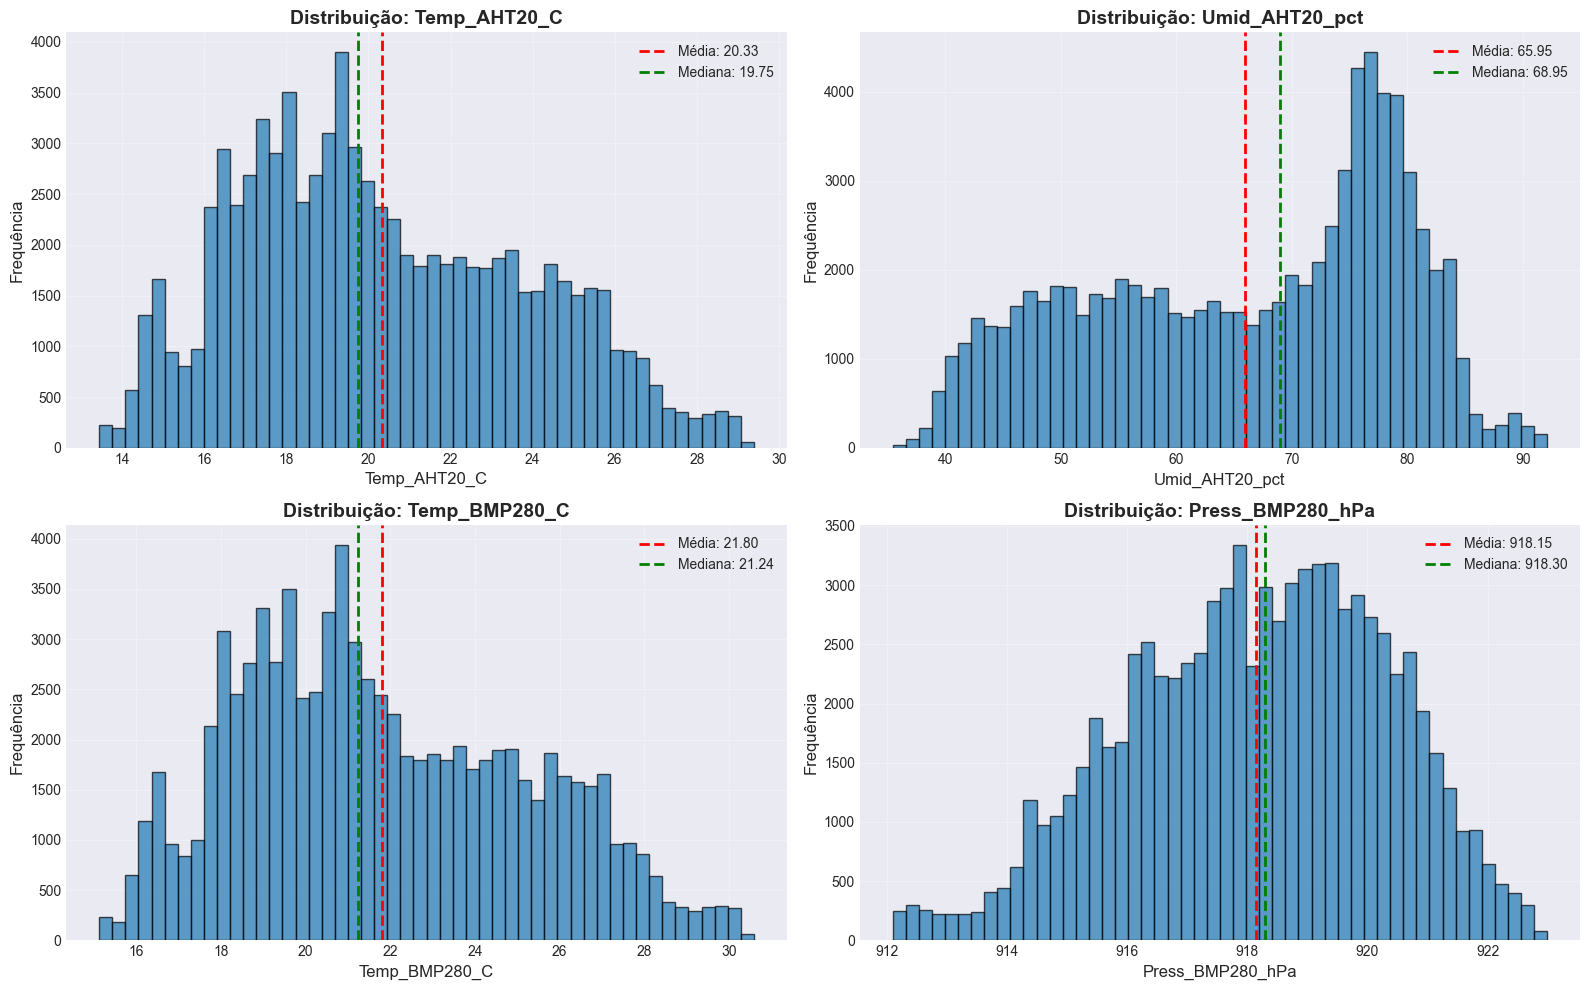

Gráfico salvo: images/Conv1D/02_distribuicao_features.png


In [27]:
# Visualizar distribuição das features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    axes[idx].hist(df[feature], bins=50, alpha=0.7, edgecolor='black')
    axes[idx].axvline(df[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df[feature].mean():.2f}')
    axes[idx].axvline(df[feature].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df[feature].median():.2f}')
    axes[idx].set_xlabel(feature, fontsize=12)
    axes[idx].set_ylabel('Frequência', fontsize=12)
    axes[idx].set_title(f'Distribuição: {feature}', fontweight='bold', fontsize=14)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/Conv1D/02_distribuicao_features.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/02_distribuicao_features.png')

## 2.3. Matriz de Correlação

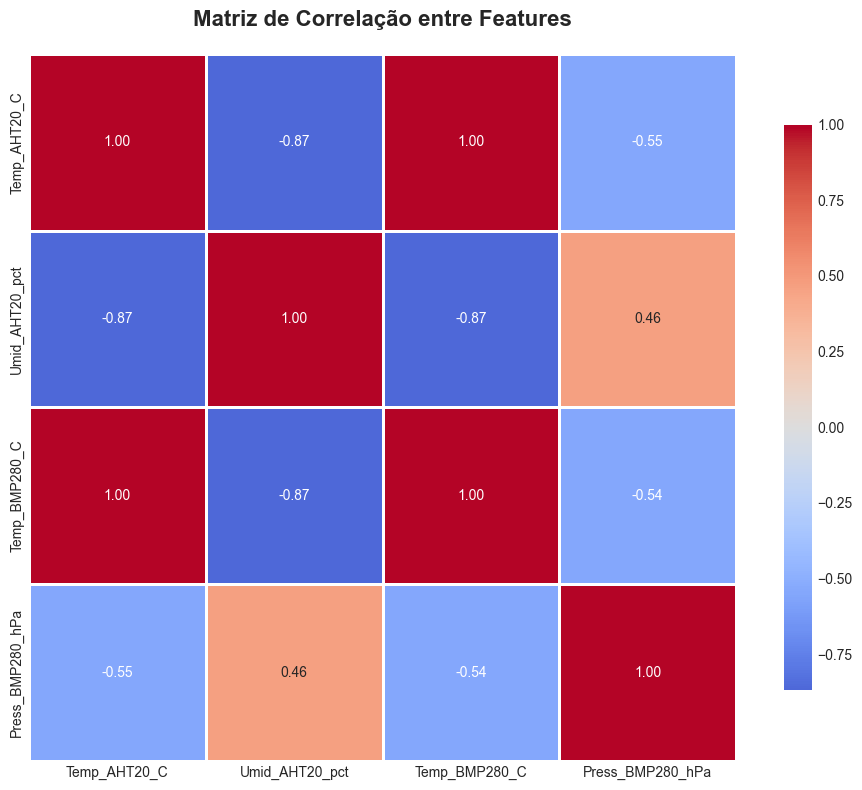

Gráfico salvo: images/Conv1D/03_matriz_correlacao.png

Correlações mais fortes com Temp_AHT20_C (target):
Temp_AHT20_C        1.000000
Temp_BMP280_C       0.999918
Press_BMP280_hPa   -0.547381
Umid_AHT20_pct     -0.869633
Name: Temp_AHT20_C, dtype: float64


In [28]:
# Calcular matriz de correlação das features selecionadas
correlation_matrix = df[features].corr()

# Visualizar matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/Conv1D/03_matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/03_matriz_correlacao.png')
print('\nCorrelações mais fortes com Temp_AHT20_C (target):')
target_corr = correlation_matrix['Temp_AHT20_C'].sort_values(ascending=False)
print(target_corr)

## 2.4. Estatísticas Resumidas

In [29]:
# Estatísticas resumidas das features
print('='*70)
print('ESTATÍSTICAS RESUMIDAS')
print('='*70)

for feature in features:
    print(f'\n{feature}:')
    print(f'  Média:    {df[feature].mean():.4f}')
    print(f'  Mediana:  {df[feature].median():.4f}')
    print(f'  Desvio:   {df[feature].std():.4f}')
    print(f'  Mínimo:   {df[feature].min():.4f}')
    print(f'  Máximo:   {df[feature].max():.4f}')
    print(f'  Variação: {df[feature].max() - df[feature].min():.4f}')

ESTATÍSTICAS RESUMIDAS

Temp_AHT20_C:
  Média:    20.3290
  Mediana:  19.7500
  Desvio:   3.4524
  Mínimo:   13.4400
  Máximo:   29.3900
  Variação: 15.9500

Umid_AHT20_pct:
  Média:    65.9464
  Mediana:  68.9500
  Desvio:   13.3431
  Mínimo:   35.4400
  Máximo:   92.1300
  Variação: 56.6900

Temp_BMP280_C:
  Média:    21.8033
  Mediana:  21.2400
  Desvio:   3.3505
  Mínimo:   15.1200
  Máximo:   30.5900
  Variação: 15.4700

Press_BMP280_hPa:
  Média:    918.1468
  Mediana:  918.3000
  Desvio:   2.1474
  Mínimo:   912.1000
  Máximo:   922.9900
  Variação: 10.8900


# 3. Pré-processamento dos Dados

---

## 3.1. Remoção de Outliers

Utilizamos o método IQR (Interquartile Range) para identificar e remover outliers.

**Fórmula:**
- Quartil 1 (Q1) = 25º percentil
- Quartil 3 (Q3) = 75º percentil
- IQR = Q3 - Q1
- Limite inferior = Q1 - 1.5 × IQR
- Limite superior = Q3 + 1.5 × IQR

In [30]:
# Aplicar remoção de outliers usando IQR
print('Remoção de outliers:')
print(f'Antes: {len(df)} amostras')

df_clean = df.copy()

for col in features:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f'Depois: {len(df_clean)} amostras')
removed = len(df) - len(df_clean)
print(f'Removidos: {removed} ({100*removed/len(df):.2f}%)')

Remoção de outliers:
Antes: 82430 amostras
Depois: 82430 amostras
Removidos: 0 (0.00%)


## 3.2. Criar Sequências Temporais

**Conceito:** Transformar dados tabulares em sequências 3D para CNN 1D

**Formato:**
- Input (X): Janela de 10 timesteps com 4 features cada
- Output (y): Temperatura futura em 3 horizontes (5, 10, 15 minutos)

**Exemplo:**
```
X = [timestep_0, timestep_1, ..., timestep_9]  <- 10 timesteps passados
y = [temp_t+10, temp_t+19, temp_t+29]           <- 3 previsões futuras
```

In [31]:
# Configurar parâmetros das sequências
WINDOW_SIZE = 10
HORIZONS = [10, 19, 29]

print('Configuração das sequências:')
print(f'  WINDOW_SIZE = {WINDOW_SIZE} timesteps')
print(f'  HORIZONS = {HORIZONS}')
print(f'\nIsso significa:')
print(f'  - Observar últimos {WINDOW_SIZE * 31 / 60:.1f} minutos')
print(f'  - Prever temperatura em {HORIZONS[0] * 31 / 60:.1f}, {HORIZONS[1] * 31 / 60:.1f} e {HORIZONS[2] * 31 / 60:.1f} minutos')

Configuração das sequências:
  WINDOW_SIZE = 10 timesteps
  HORIZONS = [10, 19, 29]

Isso significa:
  - Observar últimos 5.2 minutos
  - Prever temperatura em 5.2, 9.8 e 15.0 minutos


In [ ]:
def create_sequences(data, window_size, horizons):
    """
    Criar sequências temporais para treinamento
    
    Parâmetros:
    - data: DataFrame com os dados
    - window_size: tamanho da janela de observação
    - horizons: lista de horizontes de previsão
    
    Retorna:
    - X: array 3D (samples, timesteps, features)
    - y: array 2D (samples, horizons)
    """
    X, y = [], []
    target = 'Temp_AHT20_C'
    
    for i in range(len(data) - window_size - max(horizons)):
        X.append(data.iloc[i:i+window_size][features].values)
        y.append([data.iloc[i+window_size+h][target] for h in horizons])
    
    return np.array(X), np.array(y)

# Criar sequências
X, y = create_sequences(df_clean, WINDOW_SIZE, HORIZONS)

print('Sequências criadas com sucesso!')
print(f'\nX shape: {X.shape}')
print(f'  - {X.shape[0]} amostras')
print(f'  - {X.shape[1]} timesteps por amostra')
print(f'  - {X.shape[2]} features por timestep')
print(f'\ny shape: {y.shape}')
print(f'  - {y.shape[0]} amostras')
print(f'  - {y.shape[1]} horizontes de previsão')

## 3.3. Divisão em Treino, Validação e Teste

**Divisão:**
- Treino: 70% dos dados (para treinar o modelo)
- Validação: 15% dos dados (para ajustar hiperparâmetros)
- Teste: 15% dos dados (para avaliar desempenho final)

In [ ]:
# Dividir dados em treino, validação e teste
train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

print('Dados divididos:')
print(f'  Treino:    {len(X_train):6d} amostras ({100*len(X_train)/len(X):.1f}%)')
print(f'  Validação: {len(X_val):6d} amostras ({100*len(X_val)/len(X):.1f}%)')
print(f'  Teste:     {len(X_test):6d} amostras ({100*len(X_test)/len(X):.1f}%)')

## 3.4. Normalização dos Dados

**Por que normalizar?**
- Features têm escalas diferentes (temperatura ~20°C, pressão ~920 hPa)
- Redes neurais aprendem melhor com dados normalizados
- Evita que features com valores grandes dominem o treinamento

**Método:** StandardScaler (Z-score normalization)
- Transforma dados para média = 0 e desvio padrão = 1
- Fórmula: (x - média) / desvio_padrão

In [ ]:
# Normalizar dados usando StandardScaler
scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print('Dados normalizados com sucesso!')
print(f'\nParâmetros do scaler:')
print(f'  Média (treino): {X_train_scaled.mean():.6f}')
print(f'  Desvio (treino): {X_train_scaled.std():.6f}')
print(f'\nMédias por feature:')
for i, name in enumerate(features):
    print(f'  {name:20s}: mean={scaler.mean_[i]:8.4f}, std={scaler.scale_[i]:8.4f}')

# 4. Construção e Treinamento do Modelo

---

## 4.1. Arquitetura do Modelo CNN 1D

**Por que CNN 1D?**
- Captura padrões temporais em dados sequenciais
- Mais leve que LSTM/GRU
- Compatível com TensorFlow Lite Micro

**Arquitetura:**
```
Input (10 timesteps × 4 features)
    |
Conv1D(24 filtros, kernel=3) + ReLU + Dropout(0.2)
    |
Conv1D(16 filtros, kernel=3) + ReLU
    |
GlobalAveragePooling1D
    |
Dense(24) + ReLU + Dropout(0.2)
    |
Dense(3) [Output: 3 previsões]
```

In [ ]:
# Construir modelo CNN 1D
model = Sequential([
    Conv1D(24, kernel_size=3, activation='relu', 
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(WINDOW_SIZE, 4),
           name='conv1d_1'),
    Dropout(0.2, name='dropout_1'),
    Conv1D(16, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           name='conv1d_2'),
    GlobalAveragePooling1D(name='global_avg_pool'),
    Dense(24, activation='relu', 
          kernel_regularizer=regularizers.l2(0.0001),
          name='dense_1'),
    Dropout(0.2, name='dropout_2'),
    Dense(3, activation='linear', name='output')
], name='CNN1D_Temperature')

# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

print('Modelo criado com sucesso!')
print('\nArquitetura:')
model.summary()

print(f'\nTotal de parâmetros: {model.count_params():,}')
print(f'Tamanho estimado: {model.count_params() * 4 / 1024:.2f} KB')

## 4.2. Configurar Callbacks

**Callbacks** são funções que executam durante o treinamento:

1. **EarlyStopping**: Para o treinamento se a validação não melhorar
2. **ReduceLROnPlateau**: Reduz learning rate quando estagnar

In [ ]:
# Configurar callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=1e-7,
        verbose=1
    )
]

print('Callbacks configurados:')
print('  - EarlyStopping (patience=50)')
print('  - ReduceLROnPlateau (factor=0.5, patience=20)')

## 4.3. Treinar o Modelo

In [ ]:
# Treinar modelo
print('Iniciando treinamento...')
print('='*70)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

print('\n' + '='*70)
print('Treinamento concluído!')

## 4.4. Visualizar Curvas de Aprendizado

In [ ]:
# Plotar curvas de loss e MAE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Curva de Loss', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAE (°C)', fontsize=12)
axes[1].set_title('Curva de MAE', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/Conv1D/04_curvas_aprendizado.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/04_curvas_aprendizado.png')

# 5. Avaliação do Modelo

---

## 5.1. Métricas no Conjunto de Teste

**Métricas utilizadas:**
- **MAE** (Mean Absolute Error): Erro médio absoluto em °C
- **RMSE** (Root Mean Squared Error): Raiz do erro quadrático médio
- **R²** (Coefficient of Determination): Quanto o modelo explica a variância

In [ ]:
# Fazer predições no conjunto de teste
y_pred = model.predict(X_test_scaled, verbose=0)

# Calcular métricas gerais
mae_overall = mean_absolute_error(y_test, y_pred)
rmse_overall = np.sqrt(mean_squared_error(y_test, y_pred))
r2_overall = r2_score(y_test, y_pred)

# Calcular MAE por horizonte
mae_t1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_t2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mae_t3 = mean_absolute_error(y_test[:, 2], y_pred[:, 2])

print('='*70)
print('RESULTADOS NO CONJUNTO DE TESTE')
print('='*70)
print(f'\nMétricas Gerais:')
print(f'  MAE:  {mae_overall:.4f} °C')
print(f'  RMSE: {rmse_overall:.4f} °C')
print(f'  R²:   {r2_overall:.4f}')
print(f'\nMAE por Horizonte:')
print(f'  T+10 (5 min):   {mae_t1:.4f} °C')
print(f'  T+19 (10 min):  {mae_t2:.4f} °C')
print(f'  T+29 (15 min):  {mae_t3:.4f} °C')
print(f'\nInformações do Modelo:')
print(f'  Parâmetros totais: {model.count_params():,}')
print(f'  Tamanho estimado: {model.count_params() * 4 / 1024:.2f} KB')

## 5.2. Gráficos de Predito vs Real

In [ ]:
# Plotar scatter plots para cada horizonte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

horizons_names = ['T+10 (5 min)', 'T+19 (10 min)', 'T+29 (15 min)']

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.4, s=15)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal')
    ax.set_xlabel('Real (°C)', fontsize=12)
    ax.set_ylabel('Predito (°C)', fontsize=12)
    ax.set_title(horizon_name, fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    ax.text(0.05, 0.95, f'MAE: {mae:.3f}°C\nR²: {r2:.3f}',
            transform=ax.transAxes, va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('images/Conv1D/05_scatter_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/05_scatter_predictions.png')

## 5.3. Séries Temporais de Predições

In [ ]:
# Plotar série temporal das predições
n_samples = 300
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.plot(y_test[:n_samples, i], label='Real', linewidth=2, alpha=0.8)
    ax.plot(y_pred[:n_samples, i], label='Predito', linewidth=2, alpha=0.8)
    ax.set_ylabel('Temperatura (°C)', fontsize=12)
    ax.set_title(horizon_name, fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Amostra', fontsize=12)
plt.tight_layout()
plt.savefig('images/Conv1D/06_timeseries_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/06_timeseries_predictions.png')

## 5.4. Análise de Erros

In [ ]:
# Calcular erros
errors = y_pred - y_test

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.hist(errors[:, i], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Erro zero')
    ax.set_xlabel('Erro (°C)', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.set_title(f'{horizon_name}: Distribuição dos Erros', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    mean_err = errors[:, i].mean()
    std_err = errors[:, i].std()
    ax.text(0.05, 0.95, f'Média: {mean_err:.3f}\nStd: {std_err:.3f}',
            transform=ax.transAxes, va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('images/Conv1D/07_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/Conv1D/07_error_distribution.png')

# 6. Conversão para TensorFlow Lite

---

## 6.1. Salvar Modelo Original

In [ ]:
# Criar pasta models/Conv1D se não existir
os.makedirs('models/Conv1D', exist_ok=True)

model.save('models/Conv1D/temperature_model.keras')
print('Modelo Keras salvo: models/Conv1D/temperature_model.keras')

## 6.2. Converter para TensorFlow Lite

In [ ]:
# Converter para TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('models/Conv1D/temperature_model.tflite', 'wb') as f:
    f.write(tflite_model)

size_kb = len(tflite_model) / 1024
print(f'Modelo TFLite salvo: models/Conv1D/temperature_model.tflite')
print(f'Tamanho: {size_kb:.2f} KB')

if size_kb < 100:
    print('Compatível com Raspberry Pi Pico (2MB Flash)')
else:
    print('AVISO: Modelo grande para microcontrolador')

## 6.3. Verificar Conversão TFLite

In [ ]:
# Testar modelo TFLite
interpreter = tf.lite.Interpreter(model_path='models/Conv1D/temperature_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print('Informações do modelo TFLite:')
print(f'  Input shape:  {input_details[0]["shape"]}')
print(f'  Input dtype:  {input_details[0]["dtype"]}')
print(f'  Output shape: {output_details[0]["shape"]}')
print(f'  Output dtype: {output_details[0]["dtype"]}')

test_sample = X_test_scaled[0:1].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])

keras_pred = model.predict(test_sample, verbose=0)

print(f'\nTeste de conversão:')
print(f'  Predição Keras:  {keras_pred[0]}')
print(f'  Predição TFLite: {tflite_pred[0]}')
print(f'  Diferença máxima: {np.abs(keras_pred - tflite_pred).max():.6f} °C')

if np.abs(keras_pred - tflite_pred).max() < 0.01:
    print('\nConversão TFLite: OK')
else:
    print('\nAVISO: Diferença significativa após conversão')

# 7. Geração de Arquivo C para RP2040

---

## 7.1. Converter Modelo TFLite para C Array

In [ ]:
def convert_to_c_array(tflite_model, var_name='model_data'):
    c_array = f"const unsigned char {var_name}[] = {{\n"
    for i in range(0, len(tflite_model), 12):
        line = "  "
        for j in range(12):
            if i + j < len(tflite_model):
                line += f"0x{tflite_model[i+j]:02x}, "
        c_array += line + "\n"
    c_array += "};\n"
    c_array += f"const unsigned int {var_name}_len = {len(tflite_model)};\n"
    return c_array

h_content = """// Temperature Prediction Model - TinyML
// Auto-generated file - Do not edit manually
// Model trained on AHT20 + BMP280 sensor data

#ifndef TEMPERATURE_MODEL_H
#define TEMPERATURE_MODEL_H

"""

h_content += convert_to_c_array(tflite_model, 'temperature_model')

h_content += """
// Model information
#define WINDOW_SIZE 10
#define NUM_FEATURES 4
#define NUM_HORIZONS 3

// Feature names
const char* feature_names[] = {
    "Temp_AHT20_C",
    "Umid_AHT20_pct",
    "Temp_BMP280_C",
    "Press_BMP280_hPa"
};

// Horizon names
const char* horizon_names[] = {
    "5 minutes",
    "10 minutes",
    "15 minutes"
};

#endif // TEMPERATURE_MODEL_H
"""

h_filename = 'models/Conv1D/temperature_model.h'
with open(h_filename, 'w') as f:
    f.write(h_content)

print(f'Arquivo {h_filename} gerado com sucesso!')
print(f'Tamanho do modelo: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)')

## 7.2. Gerar Parâmetros do Scaler para C

In [ ]:
# Gerar arquivo header com parâmetros de normalização
scaler_h_content = """// Scaler parameters for normalization
// Auto-generated file - Do not edit manually

#ifndef SCALER_PARAMS_H
#define SCALER_PARAMS_H

// Mean values
const float scaler_mean[] = {
"""

for i, mean_val in enumerate(scaler.mean_):
    scaler_h_content += f"    {mean_val:.6f}f"
    if i < len(scaler.mean_) - 1:
        scaler_h_content += ","
    scaler_h_content += f"  // {features[i]}\n"

scaler_h_content += """};\n
// Scale values
const float scaler_scale[] = {
"""

for i, scale_val in enumerate(scaler.scale_):
    scaler_h_content += f"    {scale_val:.6f}f"
    if i < len(scaler.scale_) - 1:
        scaler_h_content += ","
    scaler_h_content += f"  // {features[i]}\n"

scaler_h_content += """};\n
#endif // SCALER_PARAMS_H
"""

scaler_filename = 'models/Conv1D/scaler_params.h'
with open(scaler_filename, 'w') as f:
    f.write(scaler_h_content)

print(f'Arquivo {scaler_filename} gerado com sucesso!')
print(f'\nParâmetros do Scaler:')
print(f'  Mean: {scaler.mean_}')
print(f'  Scale: {scaler.scale_}')

## 7.3. Salvar Scaler

In [ ]:
import joblib

joblib.dump(scaler, 'models/Conv1D/scaler.pkl')
print('Scaler salvo: models/Conv1D/scaler.pkl')

# 8. Resumo Final

---

In [ ]:
print('='*70)
print('RESUMO DO PROJETO')
print('='*70)

print(f'\nDataset:')
print(f'  - Total amostras: {len(df_clean):,}')
print(f'  - Features: {features}')
print(f'  - Target: Temp_AHT20_C')
print(f'  - Período: {df_clean["Timestamp"].min()} até {df_clean["Timestamp"].max()}')

print(f'\nModelo:')
print(f'  - Arquitetura: CNN 1D (2 camadas Conv + Dense)')
print(f'  - Parâmetros: {model.count_params():,}')
print(f'  - Tamanho TFLite: {len(tflite_model)/1024:.2f} KB')
print(f'  - Compatível: TensorFlow Lite Micro')

print(f'\nPerformance (Teste):')
print(f'  - MAE Geral:    {mae_overall:.4f} °C')
print(f'  - RMSE:         {rmse_overall:.4f} °C')
print(f'  - R²:           {r2_overall:.4f}')
print(f'  - MAE (5 min):  {mae_t1:.4f} °C')
print(f'  - MAE (10 min): {mae_t2:.4f} °C')
print(f'  - MAE (15 min): {mae_t3:.4f} °C')

print(f'\nArquivos Gerados:')
print(f'  - models/Conv1D/temperature_model.keras')
print(f'  - models/Conv1D/temperature_model.tflite')
print(f'  - models/Conv1D/temperature_model.h')
print(f'  - models/Conv1D/scaler_params.h')
print(f'  - models/Conv1D/scaler.pkl')
print(f'  - images/Conv1D/01-07.png')

print(f'\nPróximos Passos:')
print(f'  1. Integrar models/Conv1D/*.h no código do RP2040')
print(f'  2. Implementar loop de leitura dos sensores')
print(f'  3. Aplicar normalização usando scaler_params.h')
print(f'  4. Executar inferência com TFLite Micro')
print(f'  5. Exibir predições de temperatura')

print('\n' + '='*70)
print('PROJETO CONCLUÍDO COM SUCESSO!')
print('='*70)